# Anneal Schedule
This notebook explores features that give you control over the D-Wave system's global [anneal schedule](#Understanding-the-Anneal-Schedule). These features can improve solutions to a problem and provide insight into the behaviour and dynamics of problems undergoing quantum annealing.

1. [Understanding the Anneal Schedule](#Understanding-the-Anneal-Schedule) explains the feature.
2. [Using Anneal Schedule Features](#Using-Anneal-Schedule-Features) shows how to use the feature with an interactive example problem.
3. [Mapping Various Anneal Schedules](#Mapping-Various-Anneal-Schedules-on-the-QPU) provides code that sweeps through various anneal schedules to explore the effect on results.

Uses of the feature are described, for example, in [The power of pausing](https://arxiv.org/abs/1810.05881) 

## Feature Availability

Availability of the anneal schedule features depends on the solver you connect to. To see whether your solver supports anneal schedule features, check solver property `max_anneal_schedule_points`  and ensure it is at least 4. 

First, we set up a connection to the quantum processing unit (QPU). Enter your token value if required.

In [3]:
from dwave.system.samplers import DWaveSampler
sampler = DWaveSampler()
print("Connected to sampler", sampler.solver.name)

Connected to sampler Advantage_system4.1


In [2]:
print("Maximum anneal schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))

Maximum anneal schedule points: 12


Your code can ensure a solver supports the feature by making it a selection criteria: `sampler = DWaveSampler(solver={'max_anneal_schedule_points__gte': 4})` selects only a QPU that supports at least 4 anneal-schedule points.

## Understanding the Anneal Schedule

The [Getting Started with the D-Wave System](https://docs.dwavesys.com/docs/latest/doc_getting_started.html) document describes quantum annealing and the [Solver Properties and Parameters](https://docs.dwavesys.com/docs/latest/doc_solver_ref.html) book describes the parameters used here.

In brief, *anneal schedule* refers to the global annealing trajectory. It specifies the normalized anneal fraction, $s$, an abstract parameter ranging from 0 to 1. $s(t)$ is a continuous function starting at $s=0$ for time $t=0$ and ending with $s=1$ at $t=t_f$, the total time of the anneal.

There are two ways to specify the anneal schedule, using two *mutually exclusive* parameters:

1. `annealing_time`: Set to a number in microseconds to specify linear growth from $s=0$ to $s=1$ over that time.
2. `annealing_schedule`: Specify a list of ($t$, $s$) pairs specifying points, which are then linearly interpolated. This feature supports two modes &mdash; mid-anneal *pause* and mid-anneal *quench* &mdash; which this tutorial explores.
   
<div class="alert alert-warning" role="alert" style="margin: 10px">
It is an error to specify both `annealing_time` and `annealing_schedule`.
</div>

The slope of a line segment is specified as $m_q = \frac{\Delta s}{\Delta t}$, with units of $\mu s^{-1}$. The maximum slope is equal to the inverse of the minimum anneal time. For example, a quench slope of $m_q = 0.5$ is equivalent to a 2 $\mu s$ standard anneal. The cell below calculates the maximum slope for your sampler.

In [10]:
annealing_range = sampler.properties["annealing_time_range"]
max_slope = 1.0/annealing_range[0]
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))
print("Maximum slope:", max_slope)

Annealing time range: [0.5, 2000.0]
Maximum slope: 2.0


A number of rules must be followed when building an anneal schedule:

* The first point must be (0,0).
* Normalized anneal fraction $s$ must increase monotonically.
* In the final point, $s$ must equal 1 and time $t$ must not exceed the maximum value in the `annealing_time_range` property.
* The number of points must be $\ge 2$. The upper bound is system-dependent &mdash; check the `max_anneal_schedule_points` property.
* The slopes of each line segment must not violate the maximum slope $m_{max}$.

**Violating these rules returns an error.** Additional rules that govern maximum slope vary by system; check the QPU properties document for your system. 

## Using Anneal Schedule Features
This section demonstrates how the pause and quench features can improve solutions for an example problem. We use the 16-qubit system shown below, which was studied in https://www.nature.com/articles/ncomms2920, and has an energy gap of 4 between the classical ground state and excited states.

This system is set up as shown in the image below, where dots are qubits with colors representing bias values and lines representing couplings (couplings weights are $-1$).
 
<img src='images/16q_system.png'>

The structure of this problem maps neatly to the Chimera topology of a D-Wave 2000Q QPU: it can be minor-embedded directly into two side-by-side Chimera unit cells, with each problem qubit represented by one qubit on the QPU. On Advantage systems, the problem can be similarly represented by qubits in two of the Chimera unit cell's near-counterpart structure in the Pegasus topology: $K_{4,4}$ bicliques with additional *odd* couplers.

If you were to use a standard heuristic embedder such as [minorminer](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html), however, some of the problem qubits might be represented by chains of qubits on the QPU. Instead, qubits of two ideal Chimera unit cells are used directly in the `h` and `J` definitions below and the `TilingComposite` composite scans adjacent unit cells on the QPU, finds adjacent pairs in which all the required qubits and couplers are available, and translates the one-to-one minor-embedding of the problem from the first two adjacent pairs to the first available valid pairs.

In [5]:
h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
     8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
     (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
     (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
     (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [6]:
from dwave.system import TilingComposite, FixedEmbeddingComposite

tiled_sampler = TilingComposite(sampler, 1, 2, 4)

if tiled_sampler.num_tiles:
    sampler_embedded = FixedEmbeddingComposite(sampler, embedding=tiled_sampler.embeddings[0])
else:
    print("Unable to find two complete unit cells in QPU {}".format(sampler.solver.name))

# Runs for a specific schedule

In [7]:
import matplotlib.pyplot as plt
import numpy as np

schedule_bump=[[0., 0.], [0.1, 0.000137894], [0.2, 0.0229774], [0.3, 0.12957], [0.4,
   0.302941], [0.5, 0.5], [0.6, 0.697059], [0.7, 0.87043], [0.8, 
  0.97702], [0.9, 0.999862], [1., 1.]]

def single_run(schedule: list, anneal_time: float, runs: int):
    '''Run a single anneal schedule for specified anneal_time.
    # Parameters:
    schedule: list - linear = [[0.,0.], [1.,1.]],
    anneal_time: float - between [0.5, 2000],
    runs: int - number of runs for the success probability calculation.

    # Returns:
    [anneal_time, success probability, energy]::[float, float, array[float]].

    Plot the histogram: 
    plt.hist(energy,rwidth=1,align='left',bins=[-21,-20,-19,-18,-17,-16,-15])
    plt.show()'''
    results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',                        
                num_spin_reversal_transforms=5)  
    success = np.count_nonzero(results.record.energy == -20.0)/runs

    print("[anneal_time, Success probability] = [",[anneal_time, success],"]")
    return [anneal_time, success, results.record.energy]

In [19]:
def plot_all_data(data: list):
    x_all = [point[0] for point in data]
    y_all = [1-point[1] for point in data]

    plt.scatter(x_all,y_all)
    plt.xscale('log') 
    plt.yscale('log') 
    plt.xlabel('T')
    plt.ylabel('1-F')
    plt.title('Scatter Plot of Data')
    plt.grid(True)

    plt.show()

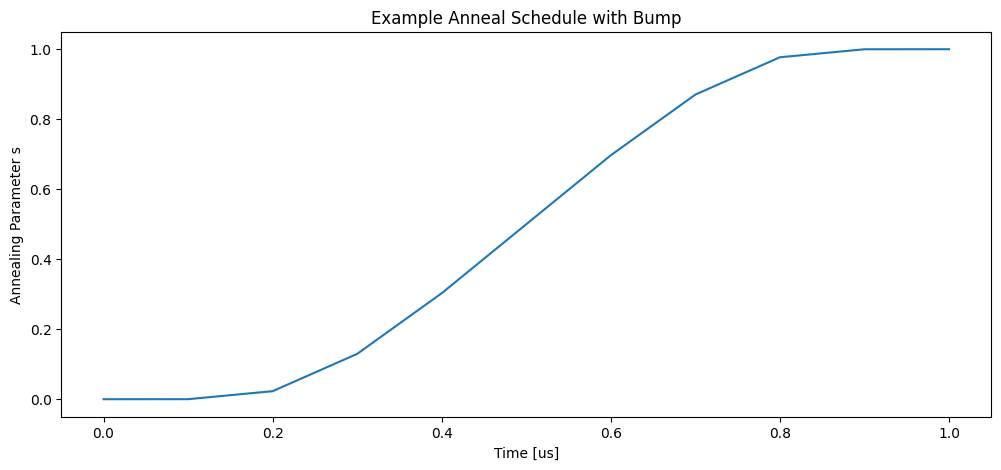

In [8]:
from helpers.draw import plot_schedule
plot_schedule(schedule_bump, "Example Anneal Schedule with Bump")

In [11]:
all_runs_bump = []
[all_runs_bump.append(single_run(schedule_bump, i, 5000)) for i in [0.5,1.,10.,50.,100.,500.,1000.,2000.]]

[anneal_time, Success probability] = [ [0.5, 0.0252] ]
[anneal_time, Success probability] = [ [1.0, 0.0314] ]
[anneal_time, Success probability] = [ [10.0, 0.039] ]
[anneal_time, Success probability] = [ [50.0, 0.035] ]
[anneal_time, Success probability] = [ [100.0, 0.036] ]
[anneal_time, Success probability] = [ [500.0, 0.024] ]
[anneal_time, Success probability] = [ [1000.0, 0.0348] ]
[anneal_time, Success probability] = [ [2000.0, 0.0278] ]


[None, None, None, None, None, None, None, None]

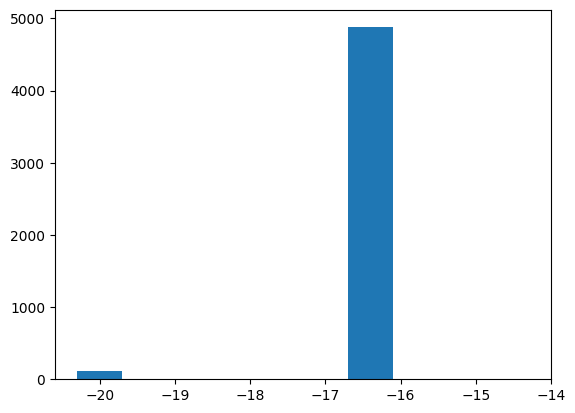

In [20]:
plt.hist(all_runs_bump[5][2],rwidth=1,align='left')
plt.show()

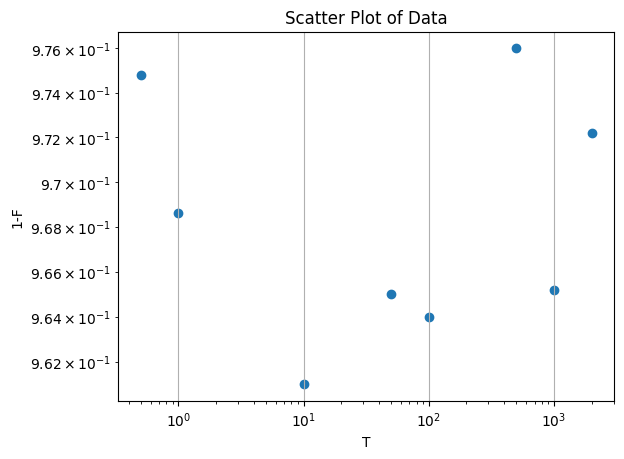

In [21]:
plot_all_data(all_runs_bump)

In [17]:
schedule_linear = [[0.,0.],[1.,1.]]
all_runs_linear = []
[all_runs_linear.append(single_run(schedule_linear, i, 5000)) for i in [0.5,1.,10.,50.,100.,500.,1000.,2000.]]

[anneal_time, Success probability] = [ [0.5, 0.0108] ]
[anneal_time, Success probability] = [ [1.0, 0.015] ]
[anneal_time, Success probability] = [ [10.0, 0.0152] ]
[anneal_time, Success probability] = [ [50.0, 0.0158] ]
[anneal_time, Success probability] = [ [100.0, 0.0114] ]
[anneal_time, Success probability] = [ [500.0, 0.0148] ]
[anneal_time, Success probability] = [ [1000.0, 0.0192] ]
[anneal_time, Success probability] = [ [2000.0, 0.0126] ]


[None, None, None, None, None, None, None, None]

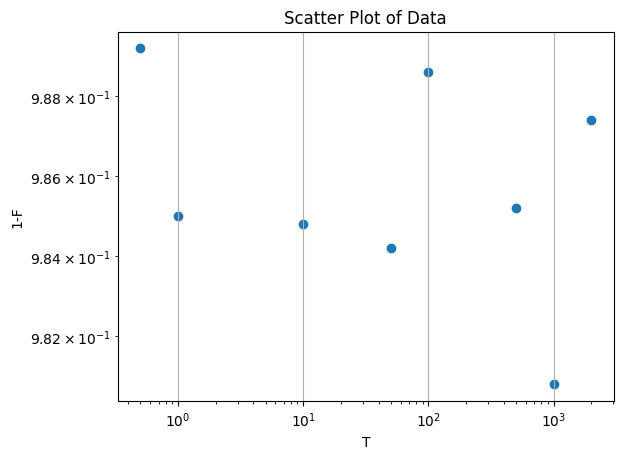

In [22]:
plot_all_data(all_runs_linear)